# add noise to a `Target`

You may want to generate a target with noise on the parameters without having to run the whole dataset + fitting process. The `get_noisy` and `get_noisy_data` ``Target`` methods are made for that.

### noise model follows the modeldag approach.

You first need to create an error model. This model will specify how the error and the error on the errors will be generated. This error model is a [modeldag](https://modeldag.readthedocs.io/) structure just like target's model. It enables to build complex structure.

In [1]:
import skysurvey
import numpy as np

***
## Most simple case, random noise on 1 parameter


### Step 0. create a timeserie target based on the "v19-2005bf" sncosmo template.

In [2]:
target = skysurvey.TSTransient.from_draw(1_000, template="v19-2005bf")
target.data.head(3)

,z,t0,magabs,magobs,amplitude,ra,dec,template
0,0.0475,56000.996094,-14.805007,21.887251,9.623834e-17,84.770103,24.457077,v19-2005bf
1,0.0285,56142.984375,-17.636517,17.916601,3.729133e-15,254.035172,22.370197,v19-2005bf
2,0.0435,56101.753906,-17.772394,18.722616,1.775013e-15,69.158661,-49.893379,v19-2005bf


### Step 1. create an errormodel for `magobs`

we assume here a random normal scatter of 0.1. This follows the [modeldag](https://modeldag.readthedocs.io/) format

In [3]:
import numpy as np
erromodel = {"magobs": {"func": np.random.normal, "kwargs":{"loc":0, "scale":0.1}} }

### Step 2. apply this to the target

You will have a warning message, because the code doesn't know who to draw the error. 

In [4]:
noisy_target = target.get_noisy(erromodel)
noisy_target.data.head(1)

/Users/rigault/miniforge3/lib/python3.9/site-packages/skysurvey/target/core.py:699: UserWarning: no error given for magobs_err entry.
  warnings.warn(f"no error given for {k}{errorlabel} entry.")


,z,t0,magabs,magobs,amplitude,ra,dec,template,magobs_true
0,0.0475,56000.996094,-14.805007,21.820488,9.623834e-17,84.770103,24.457077,v19-2005bf,21.887251


###  create an errormodel for `magobs` with errors

we assume here a random normal scatter of 0.1 with error almost perfectly measured (random error of 0.01).

The error key is specified with the "`_err`" suffix

In [5]:
# the errormodel
errorscale = 0.1
erromodel = {"magobs": {"func": np.random.normal, "kwargs":{"loc":0, "scale":errorscale}},
            "magobs_err": {"func": np.random.normal, "kwargs":{"loc":errorscale, "scale":0.01}}
            }

In [6]:
noisy_target = target.get_noisy(erromodel)
noisy_target.data.head(2)

,z,t0,magabs,magobs,amplitude,ra,dec,template,magobs_true,magobs_err
0,0.0475,56000.996094,-14.805007,21.818574,9.623834e-17,84.770103,24.457077,v19-2005bf,21.887251,0.103057
1,0.0285,56142.984375,-17.636517,17.954511,3.729133e-15,254.035172,22.370197,v19-2005bf,17.916601,0.095287


***
## errormodel with errors that depend on a variable

### depends on another variables (e.g. `magobs_err` depends on `t0`)

Create a errormodel that apply a random gaussian scatter on `magobs` which amplitude depends on t0.
Use the modeldag format `@{entryname}` to use the corresponding data entry as function input.

In [7]:
def error_depends_on_t0(t0, t0cut=56_100, prior_errors=0.1, post_errors=2):
    """ get error that depends on t0.
    
    This method returns the scatter to be applied and the corresponding errors.
    This method assumes no error on the errors.
    
    Parameters
    ----------
    t0: array
        time in the same unique as t0cut
        
    t0cut: float
        limit time defining periods
        
    prior_error: float
        errors to be applied if t0<t0cut
        
    post_errors: float
        errors to be applied if t0>=t0cut
    
    Returns
    -------
    array, array
        - scatter to be applied
        - error paramters
    """
    nentries = len(t0)
    flag_prior = np.asarray(t0<t0cut, dtype="bool") # which is prior
    
    # fill all with post_errors
    mag_errors = np.random.normal(loc=0, scale=post_errors, size=len(t0))
    mag_err_errors = np.ones(nentries) * post_errors
    
    # and overwrite the prior
    mag_errors[flag_prior] = np.random.normal(loc=0, scale=prior_errors, size=len(t0[flag_prior]))
    mag_err_errors[flag_prior] = prior_errors
    return mag_errors, mag_err_errors

In [8]:
# The error model

errormodel = {"magobs": {"func": error_depends_on_t0, 
                         "kwargs":{"t0":"@t0"},
                         # make sure to specify as since function returns 2 variables
                         "as":["magobs", "magobs_err"] 
                        }
             }

In [9]:
noisy_target = target.get_noisy(errormodel)
noisy_target.data.head(5)

,z,t0,magabs,magobs,amplitude,ra,dec,template,magobs_true,magobs_err
0,0.0475,56000.996094,-14.805007,21.926848,9.623834e-17,84.770103,24.457077,v19-2005bf,21.887251,0.1
1,0.0285,56142.984375,-17.636517,18.527147,3.729133e-15,254.035172,22.370197,v19-2005bf,17.916601,2.0
2,0.0435,56101.753906,-17.772394,19.652691,1.775013e-15,69.158661,-49.893379,v19-2005bf,18.722616,2.0
3,0.0305,56071.296875,-16.492680,19.082899,1.132111e-15,144.359772,1.116265,v19-2005bf,19.210899,0.1
4,0.0375,56100.484375,-17.466093,17.321107,1.817020e-15,43.238186,15.837475,v19-2005bf,18.697222,2.0


### depends on the true variables (e.g. `magobs_err` is in percent of `magobs`)

the `skysurvey`'s `get_noisy()` method creates the `true` entry for a variable that is affects. For instance here  `magobs_true`. Hence, if you want your error to depend on the true variable, simply use `@{entryname}_true` in the kwargs.

In [20]:
def error_depends_on_true(value, coef=0.1):
    """ get error that depends on te tru variable
    
    This method assumes no error on the errors.
    
    Parameters
    ----------
    t0: array
        time in the same unique as t0cut
        
    t0cut: float
        limit time defining periods
        
    prior_error: float
        errors to be applied if t0<t0cut
        
    post_errors: float
        errors to be applied if t0>=t0cut
    
    Returns
    -------
    array, array
        - scatter to be applied
        - error paramters
    """
    value_errors = np.random.normal(loc=0, scale=value*0.1)
    value_err_errors = value*0.1
    return value_errors, value_err_errors

In [21]:
# The error model
errormodel = {"magobs": {"func": error_depends_on_true, 
                         "kwargs":{"value":"@magobs_true"}, # <= error depend on truth
                         # make sure to specify as since function returns 2 variables
                         "as":["magobs", "magobs_err"]
                        }
             }

In [22]:
noisy_target = target.get_noisy(errormodel)
noisy_target.data.head(2)

,z,t0,magabs,magobs,amplitude,ra,dec,template,magobs_true,magobs_err
0,0.0475,56000.996094,-14.805007,25.198461,9.623834e-17,84.770103,24.457077,v19-2005bf,21.887251,2.188725
1,0.0285,56142.984375,-17.636517,18.576009,3.729133e-15,254.035172,22.370197,v19-2005bf,17.916601,1.791660


***
## Propagate

If you change a variable, you may want to affect how the forward variables (these whose values depend on the paramters you changed). For instance, in the given example, changind magobs should change "amplitude". 

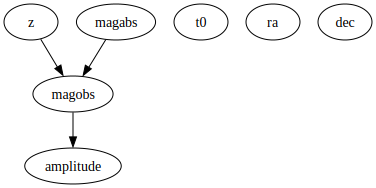

In [13]:
target.model.visualize()

to do that, set `propagate=True` in `get_noisy()`

In [14]:
# The error model
errormodel = {"magobs": {"func": error_depends_on_true, 
                         "kwargs":{"value":"@magobs_true"}, # <= error depends on truth
                         # make sure to specify as since function returns 2 variables
                         "as":["magobs", "magobs_err"]
                        }
             }

In [15]:
noisy_target = target.get_noisy(errormodel, propagate=True)
noisy_target.data.head(2)

,z,t0,magabs,magobs,amplitude,ra,dec,template,magobs_true,magobs_err
0,0.0475,56000.996094,-14.805007,19.212587,1.130351e-15,84.770103,24.457077,v19-2005bf,21.887251,2.188725
1,0.0285,56142.984375,-17.636517,18.994901,1.381300e-15,254.035172,22.370197,v19-2005bf,17.916601,1.791660


Amplitude has changed